i = : 0
i = : 10000
i = : 20000
i = : 30000
i = : 40000


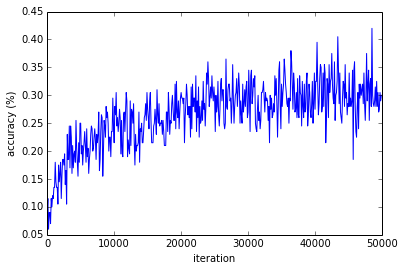

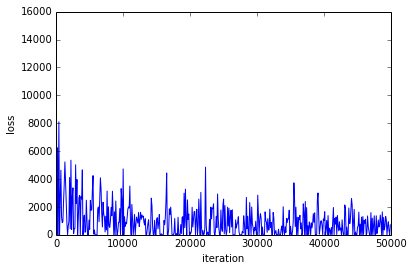

In [5]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pdb

tf.reset_default_graph()

def conv( x, filter_size=3, stride=1, num_filters=64, is_output=False, name='conv' ):

    # x is an input tensor
    x_shape = x.get_shape().as_list()
    # Declare a name scope using the "name" parameter
    with tf.variable_scope(name):
        # Create a W filter variable with the proper size
        W_conv = tf.get_variable('W' + name, shape = [filter_size,filter_size,x_shape[3],num_filters], dtype=tf.float32, initializer = tf.contrib.layers.variance_scaling_initializer())
        # Create a B bias variable withthe proper size
        B_conv = tf.Variable(tf.random_normal([num_filters]), name = 'B'+name)
        # Convolve x with W by calling the tf.nn.conv2d function
        convolve = tf.nn.conv2d(x,W_conv, strides = [1, stride, stride, 1], padding='SAME')
        # Add the bias
        convolve_bias = tf.nn.bias_add(convolve,B_conv)
        # If is_output is False,
            # Call the tf.nn.relu function
        if not is_output:
            convolve_bias = tf.nn.relu(convolve_bias, name='relu')

    return convolve_bias


def fc( x, out_size=50, is_output=False, name="fc" ):

    #x is an input tensor
    x_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        #  Create a W filter variable with the proper size
        W_fc = tf.get_variable('W' + name, shape=[out_size, x_shape[0]], dtype=tf.float32, initializer = tf.contrib.layers.variance_scaling_initializer())
        #  Create a B bias variable with the proper size
        B_fc = tf.Variable(tf.random_normal([out_size]), name = 'B' + name)
        #  Multiply x by W and add b
        out = tf.transpose(tf.nn.bias_add( tf.transpose(tf.matmul(W_fc, x)), B_fc))
        #  If is_output is False,
        if not is_output:
            out = tf.nn.relu(out, name = 'relu_fc')
        #    Call the tf.nn.relu function
#         print out.get_shape().as_list()
    return out


def reshape_cifar_image(im):
    im_new = np.zeros((1,32,32,3))
    l = 0
    for k in range(3):
        for j in range(32):
            for i in range(32):
                im_new[0,j,i,k] = im[l]
                l = l + 1
    return im_new

def unpickle( file ):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict


data1 = unpickle( '/home/radlab/Downloads/cifar-10-batches-py/data_batch_1' )
features1 = data1['data']
labels1 = data1['labels']
labels1 = np.atleast_2d( labels1 ).T
data2 = unpickle( '/home/radlab/Downloads/cifar-10-batches-py/data_batch_2' )
features2 = data2['data']
labels2 = data2['labels']
labels2 = np.atleast_2d( labels2 ).T
data3 = unpickle( '/home/radlab/Downloads/cifar-10-batches-py/data_batch_3' )
features3 = data3['data']
labels3 = data3['labels']
labels3 = np.atleast_2d( labels3 ).T
data4 = unpickle( '/home/radlab/Downloads/cifar-10-batches-py/data_batch_4' )
features4 = data4['data']
labels4 = data4['labels']
labels4 = np.atleast_2d( labels4 ).T
data5 = unpickle( '/home/radlab/Downloads/cifar-10-batches-py/data_batch_5' )
features5 = data5['data']
labels5 = data5['labels']
labels5 = np.atleast_2d( labels5 ).T
test_data = unpickle( '/home/radlab/Downloads/cifar-10-batches-py/test_batch' )
features_test = test_data['data']
labels_test = test_data['labels']
labels_test = np.atleast_2d( labels_test ).T

features = np.concatenate((features1,features2,features3,features4,features5), axis=0)
labels = np.concatenate((labels1,labels2,labels3,labels4,labels5), axis=0)


xx = tf.placeholder( tf.float32, [1,32,32,3] )
yy = tf.placeholder( tf.int64, [1] )



h0 = conv( xx, name = "h0" )
h1 = conv( h0, name = "h1" )
h2 = conv( h1, stride = 2, name = "h2" )
h2_flat = tf.reshape(h2, [-1, 1])
fc0 = fc( h2_flat, out_size = 64*32, is_output = False, name = "fc0" )

score = fc( fc0, out_size = 10, is_output = True, name = "fc1" )
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=yy, logits = tf.transpose(score), name='loss')

with tf.name_scope('accuracy'):
    # this calculates the accuracy of the classification
    classification = tf.argmax(score)
    acc = tf.equal(classification, yy)

train_weights = tf.train.AdamOptimizer(1e-6).minimize(loss)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    writer = tf.summary.FileWriter("/home/radlab/Downloads/tf_logs", sess.graph)
    tf.summary.scalar('loss', loss)
    merged = tf.summary.merge_all()

    accuracy_total = np.array([])
    loss_final = np.array([])
    for i in range(len(labels)):
#     for i in range(1000):
        x = reshape_cifar_image( features[i,:] )
        sess.run(train_weights, feed_dict = {xx: x, yy: labels[i]})
        if i%100 == 0:
            # test accuracy on the test data set
            index = np.random.choice(len(labels_test),200)
            rand_lab = labels_test[index]
            rand_feat = features_test[index,:]
            acc_sum = 0.0
            for j in range(200):
                acc_, loss_ = sess.run([acc, loss], feed_dict = {xx: reshape_cifar_image(rand_feat[j,:]), yy: rand_lab[j]})
                # ss = sess.run(merged, feed_dict = {xx: reshape_cifar_image(rand_feat[j,:]), yy: rand_lab[j]})
                acc_sum = acc_sum + acc_
            acc_final = acc_sum/200.0
#             print 'accuracy = ' + str(acc_final)
            accuracy_total = np.append(accuracy_total,acc_final)
            loss_final = np.append(loss_final, loss_)
            if i%10000 == 0:
                print 'i = : ' + str(i)
 
    plt.figure(1)
    plt.plot(np.arange(0,len(labels),100), accuracy_total)
#     plt.plot(np.arange(0,1000,100), 100*accuracy_total)
    plt.xlabel('iteration')
    plt.ylabel('accuracy (%)')
    plt.show()

    plt.figure(2)
    plt.plot(np.arange(0,len(labels),100), loss_final)
#     plt.plot(np.arange(0,1000,100), loss_final)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

writer.close()








#

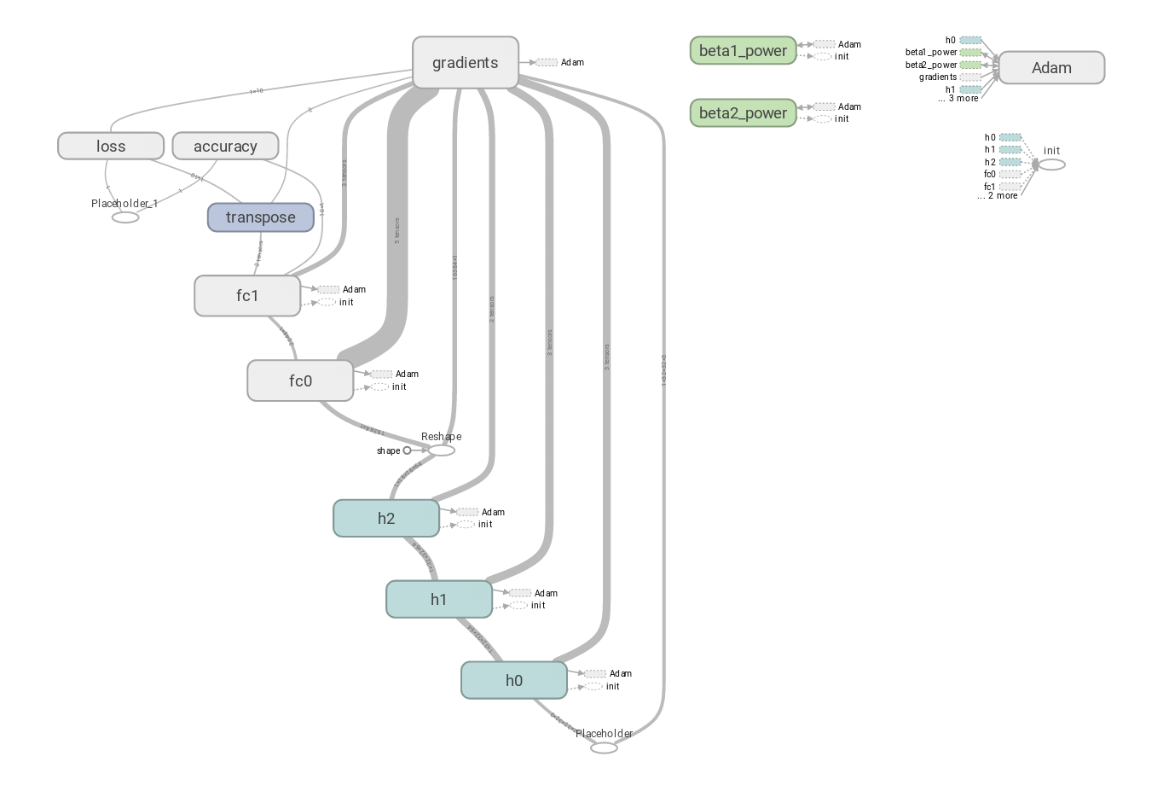

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,40))
img = mpimg.imread('tensorboard_graph.png')
plt.imshow(img)
plt.axis('off')
plt.show()